In [1]:
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import xgboost as xgb

2025-04-23 19:42:47.652621: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 19:42:47.656835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 19:42:47.670327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745417567.692150   39015 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745417567.699014   39015 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745417567.715395   39015 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<h3 style="color:#e7d3d3"> 1. IMPORTING LSTM MODELS  </h3>

In [2]:
lstm_pm25 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(PM2.5).keras")
lstm_pm10 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(PM10).keras")
lstm_no2 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(NO2).keras")
lstm_so2 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(SO2).keras")
lstm_co = load_model("/home/madhav/dev/PureDelhi/models/LSTM(CO).keras")

2025-04-23 19:42:51.614576: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<h3 style="color:#e7d3d3"> 2. IMPORTING SCALER   </h3>

In [3]:
pollutant_scaler = joblib.load("/home/madhav/dev/PureDelhi/models/pollutant_scaler.pkl")
weather_scaler = joblib.load("/home/madhav/dev/PureDelhi/models/weather_scaler.pkl")

<h3 style="color:#e7d3d3"> 3. IMPORTING XGBOOST MODELS   </h3>

In [4]:
xgb_pm25 = xgb.Booster()
xgb_pm25.load_model("/home/madhav/dev/PureDelhi/models/XGB_PM25.ubj") 

xgb_pm10 = xgb.Booster()
xgb_pm10.load_model("/home/madhav/dev/PureDelhi/models/XGB_PM10.ubj") 

xgb_no2 = xgb.Booster()
xgb_no2.load_model("/home/madhav/dev/PureDelhi/models/XGB_NO2.ubj") 

xgb_so2 = xgb.Booster()
xgb_so2.load_model("/home/madhav/dev/PureDelhi/models/XGB_SO2.ubj") 

xgb_co = xgb.Booster()
xgb_co.load_model("/home/madhav/dev/PureDelhi/models/XGB_CO.ubj") 

<h3 style="color:#e7d3d3"> 4. IMPORTING DATA  </h3>

In [5]:
pollutants_data = pd.read_csv("/home/madhav/dev/PureDelhi/data/test_data.csv",parse_dates=["Timestamp"])
weather_data = pd.read_csv("~/dev/PureDelhi/data/weather_test_data.csv",parse_dates=["Timestamp"])[7:]

weather_data.drop(columns=["Timestamp"],inplace=True)

<h3 style="color:#e7d3d3"> 5. FORECASTING FUTURE VALUE USING LSTM   </h3>

In [6]:
pollutants_data[["PM2.5","PM10","NO2","CO","SO2"]] = pollutant_scaler.transform(pollutants_data[["PM2.5","PM10","NO2","CO","SO2"]])

In [7]:
pollutants = ["PM2.5", "PM10", "NO2", "CO", "SO2"]
batches = {}

for pollutant in pollutants:
    batches[pollutant] = np.array([pollutants_data[[pollutant, "sin_month", "cos_month"]][i:i+7].values for i in range(0, len(pollutants_data)-7)])

In [8]:
forecasted_pm25 = lstm_pm25.predict(batches["PM2.5"]).reshape(-1,1)
forecasted_pm10 = lstm_pm10.predict(batches["PM10"]).reshape(-1,1)
forecasted_no2 = lstm_no2.predict(batches["NO2"]).reshape(-1,1)
forecasted_so2 = lstm_so2.predict(batches["SO2"]).reshape(-1,1)
forecasted_co = lstm_co.predict(batches["CO"]).reshape(-1,1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step


In [9]:
forecasted_pollutants = np.concatenate([forecasted_pm25,
                                       forecasted_pm10,
                                       forecasted_no2,
                                       forecasted_co,
                                       forecasted_so2], axis=1)

<h3 style="color:#e7d3d3"> 6. ADDING WEATHER PARAMETERS TO FORECASTED VALUES   </h3>

In [10]:
weather_scaled = weather_scaler.transform(weather_data)

In [11]:
final_data = np.concatenate([forecasted_pollutants,weather_scaled,pollutants_data[["sin_month","cos_month"]][7:]],axis=1)
final_data = pd.DataFrame(final_data,columns=["PM2.5","PM10","NO2","CO","SO2","Humidity",
                                              "WindSpeed","Visibility","DewPoint","Temp_F","sin_month","cos_month"])


In [12]:
final_data

,PM2.5,PM10,NO2,CO,SO2,Humidity,WindSpeed,Visibility,DewPoint,Temp_F,sin_month,cos_month
0,0.232256,0.298134,0.272510,0.321751,0.101034,0.875270,0.024490,0.087689,0.252688,0.130995,0.500000,0.866025
1,0.306991,0.384204,0.321995,0.396378,0.147179,0.857451,0.114286,0.094657,0.255376,0.135290,0.500000,0.866025
2,0.175553,0.239568,0.218308,0.286605,0.104809,0.807235,0.138776,0.134727,0.190860,0.107373,0.500000,0.866025
3,0.239559,0.313246,0.267780,0.338611,0.098663,0.757019,0.114286,0.152729,0.185484,0.130995,0.500000,0.866025
4,0.270434,0.344883,0.310957,0.376242,0.108379,0.774838,0.048980,0.141696,0.158602,0.109520,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.096061,0.221502,0.343117,0.346911,0.148139,0.614471,0.012245,0.419280,0.642473,0.601288,-0.866025,0.500000
283,0.130961,0.293540,0.398326,0.454799,0.174351,0.625810,0.024490,0.433217,0.669355,0.618468,-0.866025,0.500000
284,0.173065,0.320728,0.410048,0.523730,0.213958,0.617711,0.020408,0.535424,0.653226,0.616321,-0.866025,0.500000
285,0.154249,0.307100,0.401234,0.547177,0.207396,0.607991,0.032653,0.535424,0.674731,0.631353,-0.866025,0.500000


<h3 style="color:#e7d3d3"> 7. FINAL PREDICTION USING XGBOOST </h3>

In [13]:
AQI = pd.DataFrame()

models = models = {
    "PM2.5": xgb_pm25,
    "PM10": xgb_pm10,
    "NO2": xgb_no2,
    "SO2": xgb_so2,
    "CO": xgb_co,
}

pollutants = ["PM2.5", "PM10", "NO2", "CO","SO2"]

for pol in pollutants:
    
    input_features = final_data.drop(columns=[p for p in pollutants if p != pol])
    
    dmatrix = xgb.DMatrix(input_features)
    
    model = models[pol]
    preds = model.predict(dmatrix)
    
   
    AQI[pol] = preds


<h3 style="color:#e7d3d3"> 8. CALCULATING AQI </h3>

In [14]:
import pandas as pd

def calculate_indian_aqi(row):
   
    aqi_breakpoints = {
        'PM2.5': [
            (0, 30, 0, 50),
            (31, 60, 51, 100),
            (61, 90, 101, 200),
            (91, 120, 201, 300),
            (121, 250, 301, 400),
            (251, float('inf'), 401, 500)
        ],
        'PM10': [
            (0, 50, 0, 50),
            (51, 100, 51, 100),
            (101, 250, 101, 200),
            (251, 350, 201, 300),
            (351, 430, 301, 400),
            (431, float('inf'), 401, 500)
        ],
        'CO': [
            (0, 1.0, 0, 50),
            (1.1, 2.0, 51, 100),
            (2.1, 10, 101, 200),
            (10.1, 17, 201, 300),
            (17.1, 34, 301, 400),
            (34.1, float('inf'), 401, 500)
        ],
        'NO2': [
            (0, 40, 0, 50),
            (41, 80, 51, 100),
            (81, 180, 101, 200),
            (181, 280, 201, 300),
            (281, 400, 301, 400),
            (401, float('inf'), 401, 500)
        ],
        'SO2': [
            (0, 40, 0, 50),
            (41, 80, 51, 100),
            (81, 380, 101, 200),
            (381, 800, 201, 300),
            (801, 1600, 301, 400),
            (1601, float('inf'), 401, 500)
        ]
    }
    
    
    sub_indices = {}
    
    for pollutant in row.index:
        if pollutant in aqi_breakpoints and not pd.isna(row[pollutant]):
            concentration = row[pollutant]
           
            for (bp_lo, bp_hi, i_lo, i_hi) in aqi_breakpoints[pollutant]:
                if concentration >= bp_lo and concentration <= bp_hi:
                   
                    sub_index = ((i_hi - i_lo) / (bp_hi - bp_lo)) * (concentration - bp_lo) + i_lo
                    sub_indices[pollutant] = sub_index
                    break
            else:
    
                sub_indices[pollutant] = 500
   
    if not sub_indices:
        return None
        
    return round(max(sub_indices.values()))


In [15]:
pollutants_data[pollutants] = pollutant_scaler.inverse_transform(pollutants_data[pollutants])
actual = pollutants_data[pollutants].apply(calculate_indian_aqi,axis=1)[7:]
aqi_pred = AQI.apply(calculate_indian_aqi, axis=1)

<Axes: xlabel='Timestamp', ylabel='None'>

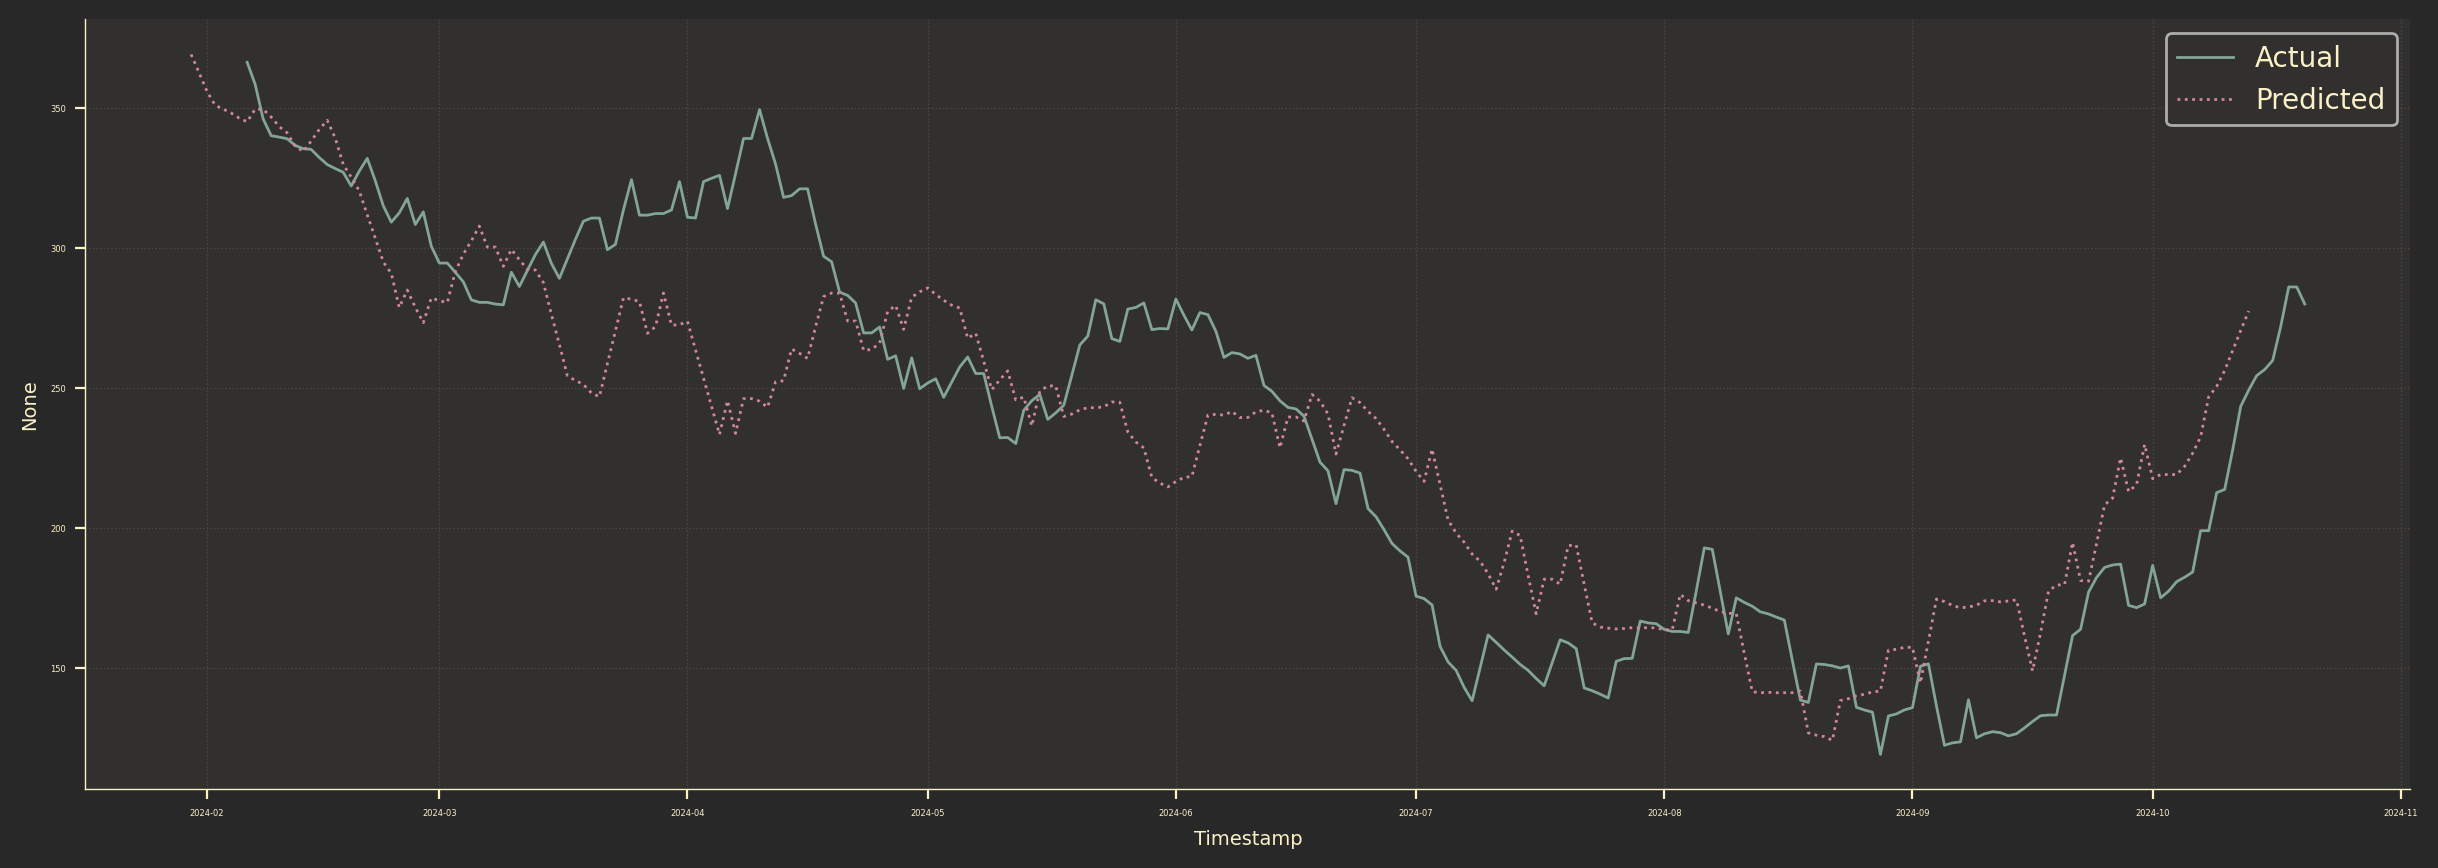

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("gruvbox.mplstyle")
plt.figure(figsize=(15, 5))
sns.lineplot(x=pollutants_data["Timestamp"][7:], y=actual.rolling(30).mean(), color="C2", label="Actual")
sns.lineplot(x=pollutants_data["Timestamp"][7:], y=aqi_pred.rolling(30).mean(), color="C3", linestyle=":", label="Predicted")